# Bias Mitigation Analysis - COMPAS

In [1]:
data_name = 'Compas'

In [2]:
from analysis_utils import *
%matplotlib inline

In [3]:
# define desired metric for the use case
ACC_METRIC = 'avg_norm_mcc_score'
FAIR_METRIC = 'abs_avg_ppvd_score'

In [4]:
import os
import pandas as pd
import numpy as np
results_all = pd.DataFrame()
dir_path = './{}_results/'.format(data_name)
for file in os.listdir(dir_path):
    print(file)
    result = pd.read_pickle(dir_path+file)
    results_all = pd.concat([results_all, result])

Compas_results_GB
Compas_results_LR
Compas_results_NB
Compas_results_RF
Compas_results_SVM
Compas_results_TabTrans


In [5]:
print(results_all.shape)
results_all.head(2)

(960, 19)


,base_estimator,param,Bias_Mitigation,threshold,avg_acc_score,avg_bacc_score,avg_f1_score,avg_auc_score,avg_mcc_score,avg_norm_mcc_score,avg_spd_score,avg_aod_score,avg_eod_score,avg_ford_score,avg_ppvd_score,avg_(1-consistency_score),avg_gei_score,avg_ti_score,cost
0,GB,"{'criterion': 'friedman_mse', 'max_depth': 8, ...",None,0.3,0.585528,0.557847,0.713569,0.709351,0.205327,0.602664,0.078415,0.070334,0.112646,0.094769,0.083604,0.076715,0.071105,0.077293,0.475751
1,GB,"{'criterion': 'friedman_mse', 'max_depth': 8, ...",None,0.4,0.639837,0.621482,0.725702,0.709351,0.292978,0.646489,0.165388,0.145861,0.213883,0.061920,0.080595,0.111480,0.096650,0.117469,0.518899


In [6]:
import seaborn as sns
accuracy_metrics = ['acc_score', 'bacc_score', 'f1_score', 'auc_score', 'mcc_score','norm_mcc_score']
group_fairness = ['spd_score', 'aod_score', 'eod_score','ford_score','ppvd_score']
individual_fairness = ['(1-consistency_score)','gei_score','ti_score']
fairness_metrics = group_fairness+individual_fairness
avg_accuracy_metrics = ['avg_'+col for col in accuracy_metrics]
avg_fairness_metrics = ['avg_'+col for col in fairness_metrics]

In [7]:
results_all_converted = results_all.copy(deep=True).reset_index(drop=True)
for col in avg_fairness_metrics:
    abs_col_name = 'abs_'+col
    results_all_converted[abs_col_name] = results_all_converted[col].abs()
# round threshold since 0.4 was 0.399999999 
results_all_converted.threshold = round(results_all_converted.threshold,2)
# base estimator invariant in-processing methods shouldn't have any parameter value
results_all_converted.loc[results_all_converted.Bias_Mitigation.isin(['AD','LFR_in']),['param']] = ''

In [8]:
base_invariant = results_all_converted.loc[results_all_converted.Bias_Mitigation.isin(['AD','LFR_in'])]
for base in results_all_converted.base_estimator.unique():
    if results_all_converted[(results_all_converted.base_estimator==base)\
                             &((results_all_converted.Bias_Mitigation=='AD')|(results_all_converted.Bias_Mitigation=='LFR_in'))].shape[0]==0:
        dup = base_invariant.copy()
        dup['base_estimator'] = dup['base_estimator'].replace({'LR':base})
        results_all_converted = pd.concat([results_all_converted, dup])
results_all_converted.head()

,base_estimator,param,Bias_Mitigation,threshold,avg_acc_score,avg_bacc_score,avg_f1_score,avg_auc_score,avg_mcc_score,avg_norm_mcc_score,...,avg_ti_score,cost,abs_avg_spd_score,abs_avg_aod_score,abs_avg_eod_score,abs_avg_ford_score,abs_avg_ppvd_score,abs_avg_(1-consistency_score),abs_avg_gei_score,abs_avg_ti_score
0,GB,"{'criterion': 'friedman_mse', 'max_depth': 8, ...",None,0.3,0.585528,0.557847,0.713569,0.709351,0.205327,0.602664,...,0.077293,0.475751,0.078415,0.070334,0.112646,0.094769,0.083604,0.076715,0.071105,0.077293
1,GB,"{'criterion': 'friedman_mse', 'max_depth': 8, ...",None,0.4,0.639837,0.621482,0.725702,0.709351,0.292978,0.646489,...,0.117469,0.518899,0.165388,0.145861,0.213883,0.061920,0.080595,0.111480,0.096650,0.117469
2,GB,"{'criterion': 'friedman_mse', 'max_depth': 8, ...",None,0.5,0.660650,0.653486,0.704836,0.709351,0.315182,0.657591,...,0.190915,0.557337,0.214928,0.185914,0.236762,0.038588,0.083137,0.124488,0.141955,0.190915
3,GB,"{'criterion': 'friedman_mse', 'max_depth': 8, ...",None,0.6,0.636098,0.643896,0.607726,0.709351,0.293926,0.646963,...,0.331047,0.504923,0.151886,0.119767,0.128976,0.038748,0.103809,0.125496,0.232619,0.331047
4,GB,"{'criterion': 'friedman_mse', 'max_depth': 8, ...",None,0.7,0.534959,0.560009,0.302813,0.709351,0.175523,0.587762,...,0.586155,0.537989,0.125751,0.109632,0.078697,0.048033,0.099379,0.093171,0.423948,0.586155


In [9]:
results_all_converted.base_estimator.value_counts()

GB          200
LR          200
NB          200
RF          200
SVM         200
TabTrans    160
Name: base_estimator, dtype: int64

In [10]:
# BEST MODELS
scoring = (ACC_METRIC,FAIR_METRIC,1,1)
w_acc = scoring[2]
w_fair = scoring[3]
acc_cost = 1-results_all_converted[ACC_METRIC]
fair_cost = abs(results_all_converted[FAIR_METRIC])

results_all_converted['cost'] = w_acc*acc_cost + w_fair*fair_cost
best_models = results_all_converted.sort_values(by='cost')[['base_estimator','param','Bias_Mitigation','threshold',
                                                            ACC_METRIC,FAIR_METRIC,'cost']].drop_duplicates(subset='cost').head(10)
best_models.rename({ACC_METRIC: 'Norm. MCC',
                    FAIR_METRIC: 'Abs. '+FAIR_METRIC.removeprefix('abs_').removeprefix('avg_').removesuffix('_score').upper()}, axis=1, inplace=True)
best_models.columns = [col if best_models.columns.get_loc(col) in [4,5]\
                       else col.replace('_',' ').title() for col in best_models.columns] 
f = {best_models.columns[i]:'{:.4f}' for i in range(-3,0)}
f.update({'Threshold':'{:.1f}'})
styled_best_models = best_models.style.format(f).hide(axis="index")
print(styled_best_models.to_latex(hrules=True, label="table:results_{}".format(data_name),
                                  caption="Top 5 Models for {}".format(data_name)).replace('_','\_'))
display(styled_best_models)

\begin{table}
\caption{Top 5 Models for Compas}
\label{table:results\_Compas}
\begin{tabular}{lllrrrr}
\toprule
Base Estimator & Param & Bias Mitigation & Threshold & Norm. MCC & Abs. PPVD & Cost \\
\midrule
GB & {'criterion': 'friedman\_mse', 'max\_depth': 8, 'n\_estimators': 10} & RW+ROC & 0.5 & 0.6508 & 0.0003 & 0.3496 \\
LR & {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'} & ROC & 0.4 & 0.6539 & 0.0054 & 0.3515 \\
LR & {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'} & None & 0.4 & 0.6541 & 0.0056 & 0.3515 \\
LR & {'C': 10, 'penalty': 'l2', 'solver': 'saga'} & ROC & 0.4 & 0.6543 & 0.0058 & 0.3516 \\
SVM & {'gamma': 'scale', 'kernel': 'rbf'} & RW+ROC & 0.5 & 0.6711 & 0.0241 & 0.3530 \\
LR & {'C': 10, 'penalty': 'l2', 'solver': 'saga'} & CEO & 0.4 & 0.6497 & 0.0037 & 0.3540 \\
LR & {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'} & CEO & 0.4 & 0.6495 & 0.0039 & 0.3544 \\
SVM & {'gamma': 'scale', 'kernel': 'poly'} & CEO & 0.5 & 0.6470 & 0.0015 & 0.3545 \\
LR & {'C': 1, 'penalty': '

Base Estimator,Param,Bias Mitigation,Threshold,Norm. MCC,Abs. PPVD,Cost
GB,"{'criterion': 'friedman_mse', 'max_depth': 8, 'n_estimators': 10}",RW+ROC,0.5,0.6508,0.0003,0.3496
LR,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",ROC,0.4,0.6539,0.0054,0.3515
LR,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",None,0.4,0.6541,0.0056,0.3515
LR,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",ROC,0.4,0.6543,0.0058,0.3516
SVM,"{'gamma': 'scale', 'kernel': 'rbf'}",RW+ROC,0.5,0.6711,0.0241,0.3530
LR,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",CEO,0.4,0.6497,0.0037,0.3540
LR,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",CEO,0.4,0.6495,0.0039,0.3544
SVM,"{'gamma': 'scale', 'kernel': 'poly'}",CEO,0.5,0.6470,0.0015,0.3545
LR,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",CEO,0.4,0.6493,0.0041,0.3548
SVM,"{'gamma': 'scale', 'kernel': 'rbf'}",ROC,0.4,0.6612,0.0164,0.3553


In [11]:
abs_avg_fairness_metrics = ['abs_'+ele for ele in avg_fairness_metrics]

## Analysis like in Chen et al. (2023)

In [12]:
diff_dict = {}
for base in results_all_converted.base_estimator.unique():
    None_table = results_all_converted[(results_all_converted.base_estimator==base)&
                                       (results_all_converted.Bias_Mitigation=='None')].reset_index(drop=True)
    diff_dict[base] = {}
    for BM in results_all_converted[results_all_converted.base_estimator==base].Bias_Mitigation.unique():
        if BM == 'None': pass
        else: 
            # print(BM)
            BM_subtable = results_all_converted[(results_all_converted.base_estimator==base)&
                                                (results_all_converted.Bias_Mitigation==BM)].reset_index(drop=True)
            diff_table = BM_subtable.iloc[:,:4]
            diff_table = pd.concat([diff_table,BM_subtable.iloc[:,4:].subtract(None_table.iloc[:,4:])], axis=1)
            diff_dict[base][BM] = diff_table

In [13]:
df = pd.DataFrame()
for base in diff_dict.keys():
    sub_df = pd.concat(diff_dict[base])
    df = pd.concat([df, pd.concat(diff_dict[base])])
df

base_estimator                                              param  \
RW 0              GB  {'criterion': 'friedman_mse', 'max_depth': 8, ...   
   1              GB  {'criterion': 'friedman_mse', 'max_depth': 8, ...   
   2              GB  {'criterion': 'friedman_mse', 'max_depth': 8, ...   
   3              GB  {'criterion': 'friedman_mse', 'max_depth': 8, ...   
   4              GB  {'criterion': 'friedman_mse', 'max_depth': 8, ...   
...              ...                                                ...   
AD 15       TabTrans                                                      
   16       TabTrans                                                      
   17       TabTrans                                                      
   18       TabTrans                                                      
   19       TabTrans                                                      

      Bias_Mitigation  threshold  avg_acc_score  avg_bacc_score  avg_f1_score  \
RW 0               RW        0.3       0.001138        0.001112      0.000924   
   1               RW        0.4      -0.006016       -0.006713     -0.002509   
   2               RW        0.5      -0.006504       -0.006900     -0.004137   
   3               RW        0.6      -0.003740       -0.004359     -0.000077   
   4               RW        0.7      -0.010244       -0.009460     -0.028628   
...               ...        ...            ...             ...           ...   
AD 15              AD        0.3       0.102764        0.111230      0.054171   
   16              AD        0.4       0.100813        0.107531      0.070410   
   17              AD        0.5       0.135772        0.126636      0.232975   
   18              AD        0.6       0.124878        0.114269      0.311845   
   19              AD        0.7       0.094959        0.086201      0.307019   

       avg_auc_score  avg_mcc_score  avg_norm_mcc_score  ...  avg_ti_score  \
RW 0       -0.010725       0.003063            0.001532  ...     -0.000852   
   1       -0.010725      -0.011316           -0.005658  ...     -0.001784   
   2       -0.010725      -0.013508           -0.006754  ...      0.001151   
   3       -0.010725      -0.009945           -0.004972  ...     -0.002297   
   4       -0.010725      -0.020836           -0.010418  ...      0.019664   
...              ...            ...                 ...  ...           ...   
AD 15       0.120483       0.257905            0.128953  ...      0.004473   
   16       0.120483       0.222873            0.111437  ...     -0.015868   
   17       0.120483       0.238548            0.119274  ...     -0.196837   
   18       0.120483       0.236494            0.118247  ...     -0.225909   
   19       0.120483       0.197768            0.098884  ...     -0.196971   

           cost  abs_avg_spd_score  abs_avg_aod_score  abs_avg_eod_score  \
RW 0  -0.016761          -0.033448          -0.036562          -0.059350   
   1   0.064645          -0.078899          -0.080776          -0.100568   
   2   0.065086          -0.146038          -0.147947          -0.164267   
   3   0.051777          -0.150051          -0.091368          -0.126621   
   4   0.041687          -0.120080          -0.104652          -0.068028   
...         ...                ...                ...                ...   
AD 15 -0.395458           0.083422           0.060569           0.085249   
   16 -0.065441           0.033456           0.011958           0.039527   
   17 -0.140738          -0.034045          -0.061395          -0.024314   
   18 -0.075684          -0.060863          -0.039226          -0.039457   
   19 -0.065765           0.004844           0.032448           0.010495   

       abs_avg_ford_score  abs_avg_ppvd_score  abs_avg_(1-consistency_score)  \
RW 0             0.012930           -0.015230                       0.001821   
   1             0.019054            0.058987                       0.003870   
   2             0.038549            0.058

In [14]:
(df.iloc[:,4:10]>0).sum()/df.shape[0]

avg_acc_score         0.278846
avg_bacc_score        0.281731
avg_f1_score          0.282692
avg_auc_score         0.271154
avg_mcc_score         0.281731
avg_norm_mcc_score    0.281731
dtype: float64

In [15]:
(df[df.Bias_Mitigation=='RW'].avg_norm_mcc_score>0).value_counts(normalize=True)

False    0.683333
True     0.316667
Name: avg_norm_mcc_score, dtype: float64

### Accuracy Behavior After Bias Mitigations

,avg_acc_score,avg_bacc_score,avg_f1_score,avg_auc_score,avg_mcc_score,avg_norm_mcc_score
noorincrease,33,34,42,17,32,32
small,0,0,0,7,0,0
medium,3,1,4,2,1,1
large,16,17,6,26,19,19


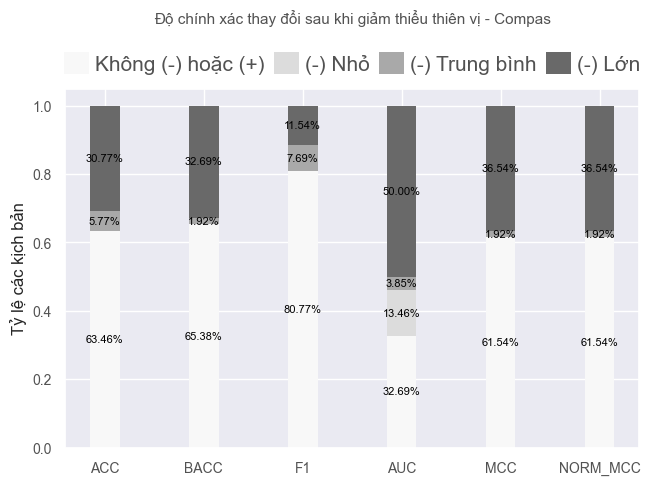

In [16]:
diff_degree = behaviour_analysis(data=results_all_converted, metric_list=avg_accuracy_metrics)
display(pd.DataFrame(diff_degree))
plot_behaviour_analysis(diff_degree, data_name, caption='Độ chính xác thay đổi sau khi giảm thiểu thiên vị - {}', figsize=(8, 6))

### Accuracy Behavior After Bias Mitigations per BM

,RW,LFR_pre,EGR,ROC,CEO,RW+ROC,RW+CEO,LFR_in,AD
noorincrease,6,0,2,6,4,6,2,0,6
small,0,0,0,0,0,0,0,0,0
medium,0,0,0,0,0,0,1,0,0
large,0,5,3,0,2,0,3,6,0


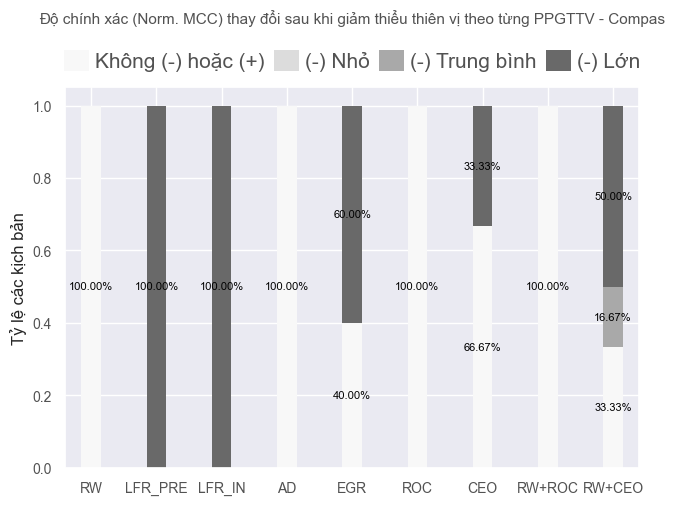

In [17]:
diff_degree = behaviour_analysis(data=results_all_converted, metric_list=[ACC_METRIC], category='bm')
display(pd.DataFrame(diff_degree))
plot_behaviour_analysis(diff_degree, data_name, category='bm', 
                        caption='Độ chính xác (Norm. MCC) thay đổi sau khi giảm thiểu thiên vị theo từng PPGTTV - {}', figsize=(8, 6))

### Accuracy Behavior After Bias Mitigations per base

,GB,LR,NB,RF,SVM,TabTrans
noorincrease,6,5,4,5,6,6
small,0,0,0,0,0,0
medium,1,0,0,0,0,0
large,2,4,5,4,3,1


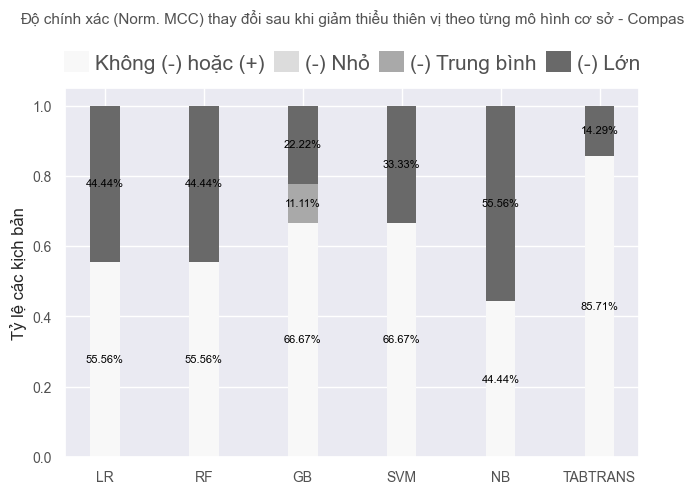

In [18]:
diff_degree = behaviour_analysis(data=results_all_converted, metric_list=[ACC_METRIC], category='base')
display(pd.DataFrame(diff_degree))
plot_behaviour_analysis(diff_degree, data_name, category='base', 
                        caption='Độ chính xác (Norm. MCC) thay đổi sau khi giảm thiểu thiên vị theo từng mô hình cơ sở - {}', figsize=(8, 6))

### Fairness Behavior After Bias Mitigations

,abs_avg_spd_score,abs_avg_aod_score,abs_avg_eod_score,abs_avg_ford_score,abs_avg_ppvd_score,abs_avg_(1-consistency_score),abs_avg_gei_score,abs_avg_ti_score
noorincrease,23,23,22,50,46,38,52,52
small,2,2,2,1,1,0,0,0
medium,2,3,2,1,0,0,0,0
large,25,24,26,0,5,14,0,0


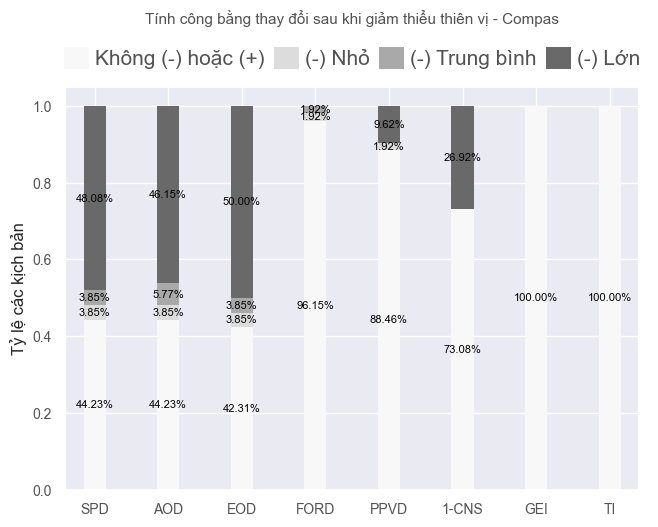

In [19]:
abs_avg_fairness_metrics = ['abs_'+ele for ele in avg_fairness_metrics]
diff_degree = behaviour_analysis(data=results_all_converted, metric_list=abs_avg_fairness_metrics)
display(pd.DataFrame(diff_degree))
plot_behaviour_analysis(diff_degree, data_name, caption='Tính công bằng thay đổi sau khi giảm thiểu thiên vị - {}', figsize=(8, 6))

### Fairness Behavior After Bias Mitigations per BM

,RW,LFR_pre,EGR,ROC,CEO,RW+ROC,RW+CEO,LFR_in,AD
noorincrease,6,4,4,6,5,6,6,3,6
small,0,1,0,0,0,0,0,0,0
medium,0,0,0,0,0,0,0,0,0
large,0,0,1,0,1,0,0,3,0


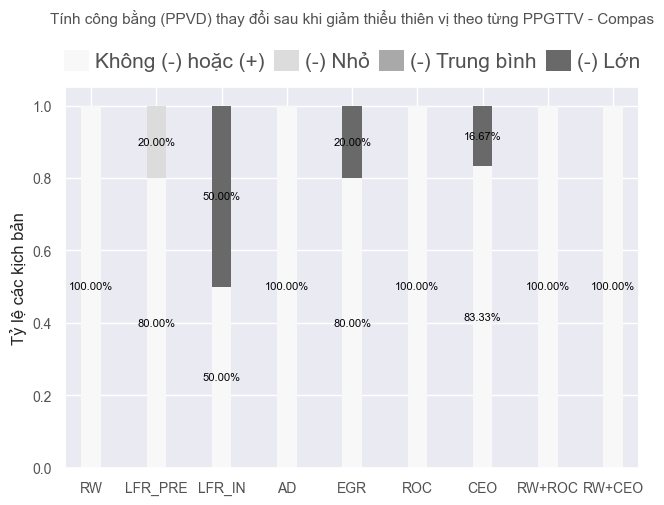

In [20]:
abs_avg_fairness_metrics = ['abs_'+ele for ele in avg_fairness_metrics]
diff_degree = behaviour_analysis(data=results_all_converted, metric_list=[FAIR_METRIC], category='bm')
display(pd.DataFrame(diff_degree))
plot_behaviour_analysis(diff_degree, data_name, category='bm', 
                        caption='Tính công bằng (%s) thay đổi sau khi giảm thiểu thiên vị theo từng PPGTTV - {}'%(FAIR_METRIC.split('_')[2].upper()),
                        figsize=(8, 6))

### Fairness Behavior After Bias Mitigations per base

,GB,LR,NB,RF,SVM,TabTrans
noorincrease,8,9,9,5,9,6
small,0,0,0,1,0,0
medium,0,0,0,0,0,0
large,1,0,0,3,0,1


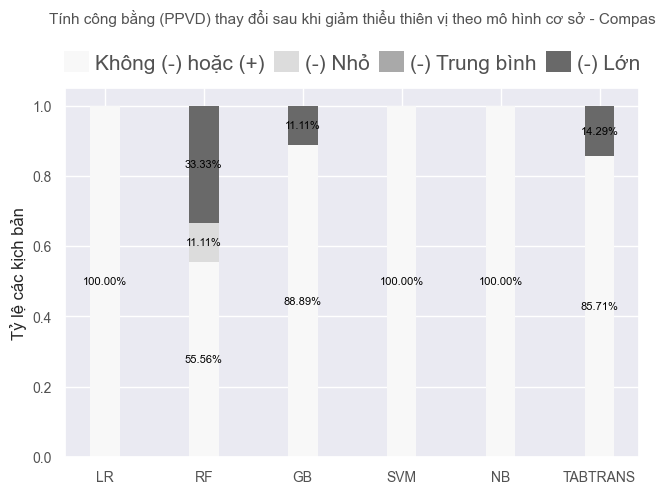

In [21]:
abs_avg_fairness_metrics = ['abs_'+ele for ele in avg_fairness_metrics]
diff_degree = behaviour_analysis(data=results_all_converted, metric_list=[FAIR_METRIC], category='base')
display(pd.DataFrame(diff_degree))
plot_behaviour_analysis(diff_degree, data_name, category='base', 
                        caption='Tính công bằng (%s) thay đổi sau khi giảm thiểu thiên vị theo mô hình cơ sở - {}'%(FAIR_METRIC.split('_')[2].upper()),
                        figsize=(8, 6))

## Accuracy vs. Fairness

### General Results

(slope > 0: trade-off)
We can see from the graphs below:

1. Overall trend: the higher the accuracy, the lower the group fairness (positive slope)
2. But the choice of metrics does matter:
    - group fairness: ford_score showcased no "trade-offs"
    - accuracy metrics: f1_score and roc_auc_score showed milder "trade-offs"
    - same fairness metric combined with different accuracy metrics can present both positive/negative relations, vice versa

In [22]:
import matplotlib.pyplot as plt

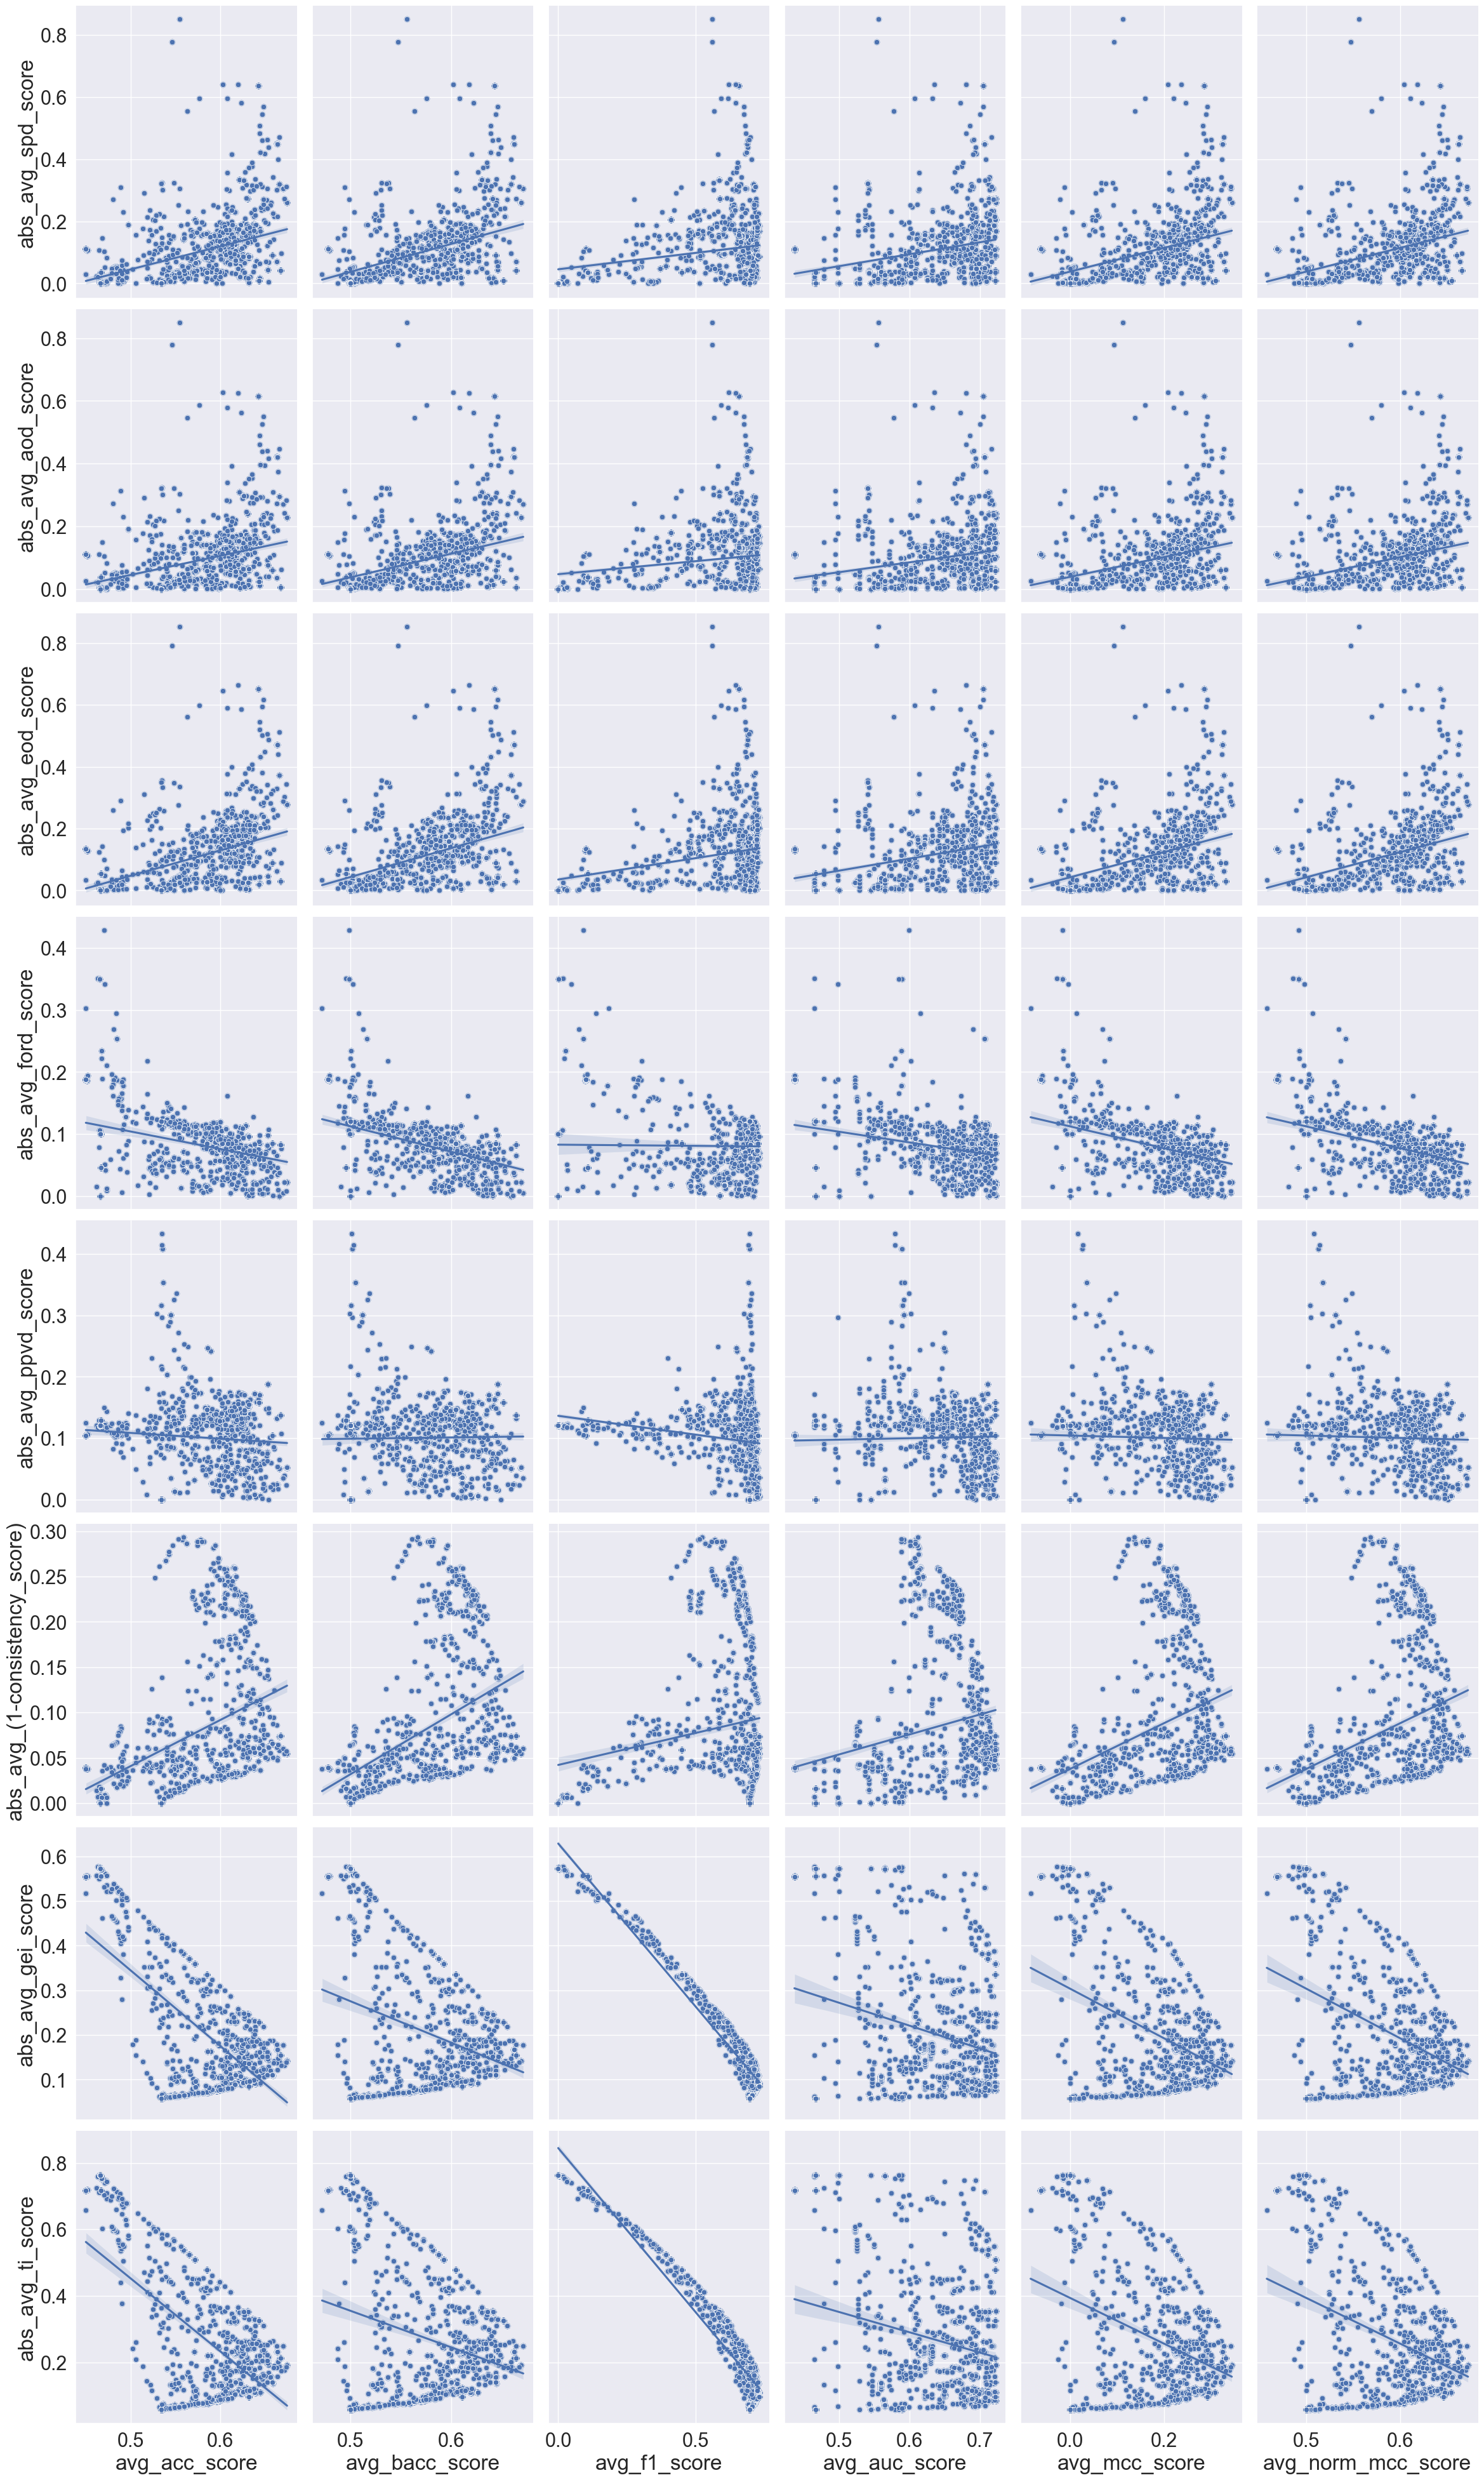

In [23]:
# Set plot font
plt.rcParams.update({'font.family':'serif'})
plt.rcParams.update({'font.serif':'Times New Roman'})

sns.set(font_scale = 2)
abs_fairness_metrics = ['abs_'+col for col in avg_fairness_metrics]
g = sns.pairplot(data=results_all_converted, x_vars=avg_accuracy_metrics, y_vars=abs_fairness_metrics,
             height=5, aspect=.8, kind="reg")
g.map(sns.scatterplot)

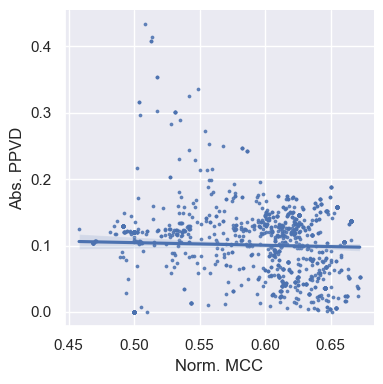

In [24]:
sns.set(font_scale = 1)
g = sns.lmplot(data=results_all_converted, x=ACC_METRIC, y=FAIR_METRIC, height=4, scatter_kws={'s':3})
# .fig.suptitle("Graph (a)")
ax = plt.gca()
ax.set(xlabel='Norm. MCC', ylabel='Abs. '+FAIR_METRIC.removeprefix('abs_').removeprefix('avg_').removesuffix('_score').upper())
# save plot
g.savefig('./Result_Plots/'+data_name+'_2D_general'+'.png', bbox_inches='tight')

### Base_estimator specific Results

We can see from the graphs below:
1. Different base_estimators can also generate very different results:
    - SVM (red) the least robust, while "NB" manifest clear trend
    - base_estimators divided into two groups when it comes to consistency_score: tree-based, ensemble (trade-offs) vs non tree-based, non ensemble

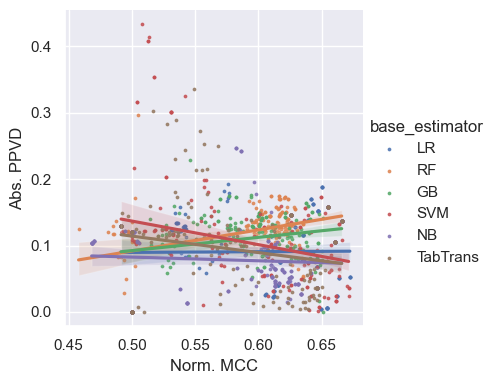

In [25]:
sns.set(font_scale = 1)
g = sns.lmplot(data=results_all_converted, x=ACC_METRIC, y=FAIR_METRIC, hue='base_estimator', 
               hue_order = ['LR','RF','GB','SVM','NB','TabTrans'], height=4, scatter_kws={'s':3})
ax = plt.gca()
ax.set(xlabel='Norm. MCC', ylabel='Abs. '+FAIR_METRIC.removeprefix('abs_').removeprefix('avg_').removesuffix('_score').upper())
# save plot
g.savefig('./Result_Plots/'+data_name+'_2D_Base'+'.png', bbox_inches='tight')

### Threshold specific Results

We can see from the graphs below:

1. Using different threshold also yiels different results:
    - most obvious with (f1_score, group_fairness) combinations

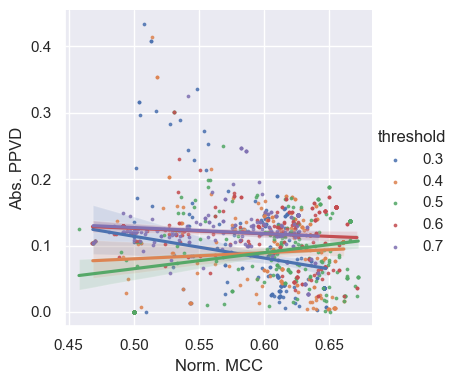

In [26]:
sns.set(font_scale = 1)
g = sns.lmplot(data=results_all_converted, x=ACC_METRIC, y=FAIR_METRIC, hue='threshold', height=4, scatter_kws={'s':3})
ax = plt.gca()
ax.set(xlabel='Norm. MCC', ylabel='Abs. '+FAIR_METRIC.removeprefix('abs_').removeprefix('avg_').removesuffix('_score').upper())
# save plot
g.savefig('./Result_Plots/'+data_name+'_2D_threshold'+'.png', bbox_inches='tight')

### Bias_mitigation specific Results

We can see from the graphs below:

1. Results are clearly divided into two groups
2. Generally with wide C.I.

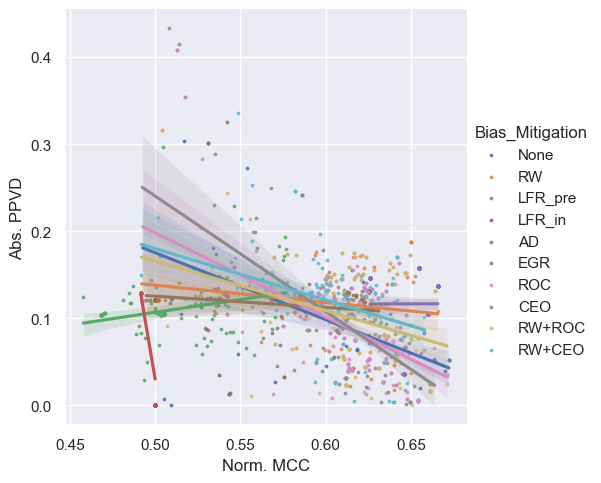

In [27]:
sns.set(font_scale = 1)
g = sns.lmplot(data=results_all_converted, x=ACC_METRIC, y=FAIR_METRIC, hue='Bias_Mitigation', 
               hue_order=['None','RW','LFR_pre','LFR_in','AD','EGR','ROC','CEO','RW+ROC','RW+CEO'],
               scatter_kws={'s': 3}, height=5)
ax = plt.gca()
ax.set(xlabel='Norm. MCC', ylabel='Abs. '+FAIR_METRIC.removeprefix('abs_').removeprefix('avg_').removesuffix('_score').upper())
# save plot
g.savefig('./Result_Plots/'+data_name+'_2D_BM'+'.png', bbox_inches='tight')

In [28]:
# sns.set(font_scale = 1)
# for base in results_all_converted.base_estimator.unique():
#     g = sns.lmplot(data=results_all_converted[results_all_converted.base_estimator==base],
#                    x=ACC_METRIC, y=FAIR_METRIC, hue="Bias_Mitigation", height=4).fig.suptitle(base)

### Bias Mitigation Category

In [29]:
bm_category = {'PRE':['RW', 'LFR_pre'],
               'IN': ['LFR_in','AD','EGR'],
               'POST':['ROC','CEO'],
               'PRE+POST':['RW+ROC','RW+CEO']}

In [30]:
results_all_converted['BM_Category'] = results_all_converted['Bias_Mitigation'].replace({v: k for k, l in bm_category.items()\
                                                                                         for v in l})
results_all_converted[['Bias_Mitigation','BM_Category']].drop_duplicates()

,Bias_Mitigation,BM_Category
0,None,None
5,RW,PRE
10,LFR_pre,PRE
15,EGR,IN
20,ROC,POST
25,CEO,POST
30,RW+ROC,PRE+POST
35,RW+CEO,PRE+POST
175,LFR_in,IN
180,AD,IN


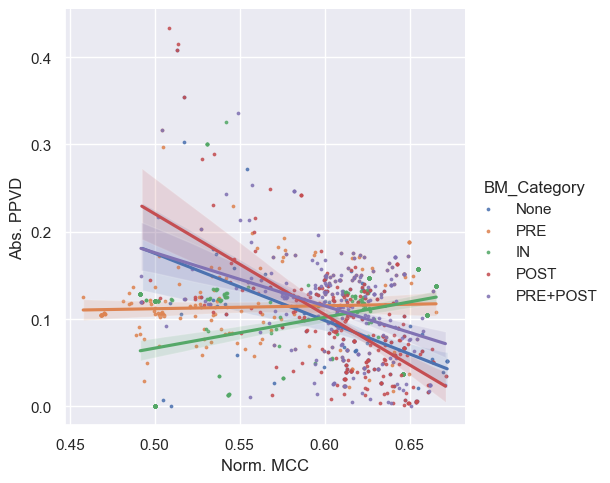

In [31]:
sns.set(font_scale = 1)
g = sns.lmplot(data=results_all_converted, x=ACC_METRIC, y=FAIR_METRIC, hue='BM_Category', 
               scatter_kws={'s': 3}, height=5)
ax = plt.gca()
ax.set(xlabel='Norm. MCC', ylabel='Abs. '+FAIR_METRIC.removeprefix('abs_').removeprefix('avg_').removesuffix('_score').upper())
# save plot
g.savefig('./Result_Plots/'+data_name+'_2D_BM_Category'+'.png', bbox_inches='tight')

In [32]:
# sns.set(font_scale = 1)
# for base in results_all_converted.base_estimator.unique():
#     g = sns.lmplot(data=results_all_converted[results_all_converted.base_estimator==base],
#                    x=ACC_METRIC, y=FAIR_METRIC, hue="BM_Category", height=4).fig.suptitle(base)

## Heatmap

No clear trend between group and individual fairness with a few exceptions

In [33]:
# g = sns.pairplot(data=results_all_converted,
#                  x_vars=['abs_avg_'+col for col in group_fairness], y_vars=['abs_avg_'+col for col in individual_fairness],
#              height=5, aspect=.8, kind="reg")
# g.map(sns.scatterplot)

In [34]:
# change column name so metrics name get more concise in the heatmaps
accuracy_map = [col.removeprefix('avg_').removesuffix('_score').upper() for col in avg_accuracy_metrics]
print(accuracy_map)
fairness_map = [col.removeprefix('abs_').removeprefix('avg_').removesuffix('_score').upper() for col in abs_avg_fairness_metrics]
fairness_map = ['1-CNS' if x=='(1-CONSISTENCY_SCORE)' else x for x in fairness_map]
print(fairness_map)

acc_rename = {avg_accuracy_metrics[i]:accuracy_map[i] for i in range(len(accuracy_map))}
fair_rename = {abs_avg_fairness_metrics[i]:fairness_map[i] for i in range(len(fairness_map))}
results_all_converted = results_all_converted.rename(columns=acc_rename).rename(columns=fair_rename)

['ACC', 'BACC', 'F1', 'AUC', 'MCC', 'NORM_MCC']
['SPD', 'AOD', 'EOD', 'FORD', 'PPVD', '1-CNS', 'GEI', 'TI']


### Original Metrics

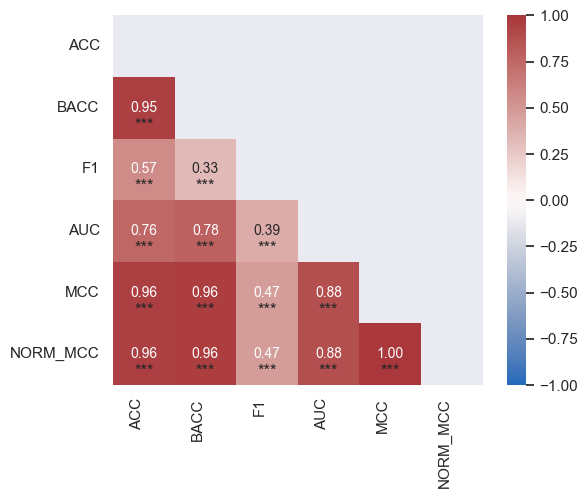

In [35]:
# original, spearman
g = corr_heatmap_with_significance(results_all_converted[accuracy_map], acc=True)
g.figure.savefig('./Heatmap/'+data_name+'_original_acc_corr'+'.png', bbox_inches='tight')
# corr_heatmap_with_significance(results_all_converted[accuracy_map+fairness_map])

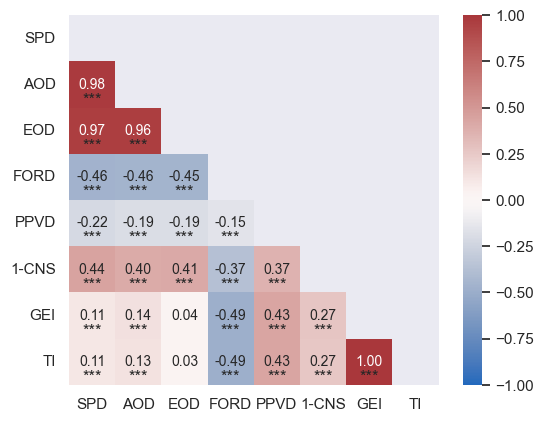

In [36]:
# original, spearman
g = corr_heatmap_with_significance(results_all_converted[fairness_map])
g.figure.savefig('./Heatmap/'+data_name+'_original_fair_corr'+'.png', bbox_inches='tight')
# corr_heatmap_with_significance(results_all_converted[accuracy_map+fairness_map])

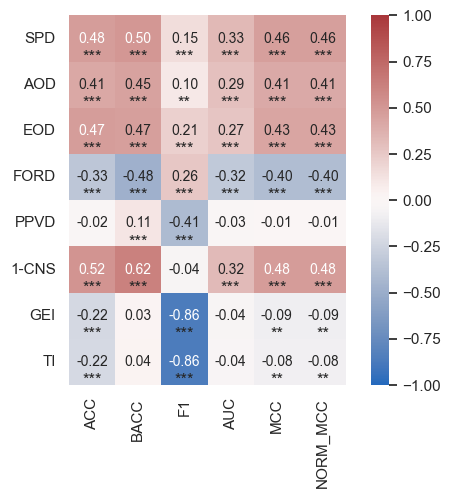

In [37]:
# original, spearman
g = corr_heatmap_with_significance_acc_fair(results_all_converted[accuracy_map+fairness_map])
g.figure.savefig('./Heatmap/'+data_name+'_original_acc_fair_corr'+'.png', bbox_inches='tight')

### Changes of Metrics

In [38]:
df_metric_diff = get_df_metric_diff(results_all_converted, metric_list=accuracy_map+fairness_map)
df_metric_diff

,dataset,base_estimator,Bias_Mitigation,ACC,BACC,F1,AUC,MCC,NORM_MCC,SPD,AOD,EOD,FORD,PPVD,1-CNS,GEI,TI
0,dataset,TabTrans,RW,0.022602,0.025816,0.006217,0.023414,0.059535,0.029767,0.037634,0.033844,0.047083,-0.009528,-0.146525,0.011740,0.008072,0.012269
1,dataset,TabTrans,RW,0.001626,0.002047,-0.000162,0.025670,0.009030,0.004515,0.004038,0.003855,0.006153,-0.001235,0.159112,0.003415,0.001461,0.002384
2,dataset,TabTrans,RW,0.036585,0.041430,0.011527,0.016675,0.088572,0.044286,0.057483,0.050192,0.069226,-0.015826,-0.004948,0.011220,0.011260,0.016895
3,dataset,TabTrans,RW,0.019837,0.017904,0.025711,0.024086,0.041777,0.020888,0.014583,0.010952,0.013932,-0.006113,-0.179082,-0.001561,-0.019544,-0.028809
4,dataset,TabTrans,RW,0.010732,0.010530,0.009263,0.023414,0.027548,0.013774,0.015961,0.016768,0.035976,-0.009954,-0.091771,-0.009398,-0.004922,-0.008132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,dataset,TabTrans,AD,0.124878,0.114269,0.311845,0.120483,0.236494,0.118247,-0.060863,-0.039226,-0.039457,-0.158374,0.042563,-0.000390,-0.181893,-0.225909
16,dataset,TabTrans,AD,0.111870,0.098409,0.418119,0.072746,0.234238,0.117119,0.028852,0.052608,0.025329,0.072293,0.028470,0.052423,-0.221126,-0.266116
17,dataset,TabTrans,AD,0.090407,0.087394,0.226731,0.192905,0.221006,0.110503,-0.024833,0.002206,-0.018735,0.002031,0.041133,-0.003967,-0.128660,-0.136308
18,dataset,TabTrans,AD,0.089106,0.079404,0.308844,0.045146,0.183093,0.091547,-0.000651,0.027032,-0.008024,0.046107,0.024503,0.034211,-0.167761,-0.199890


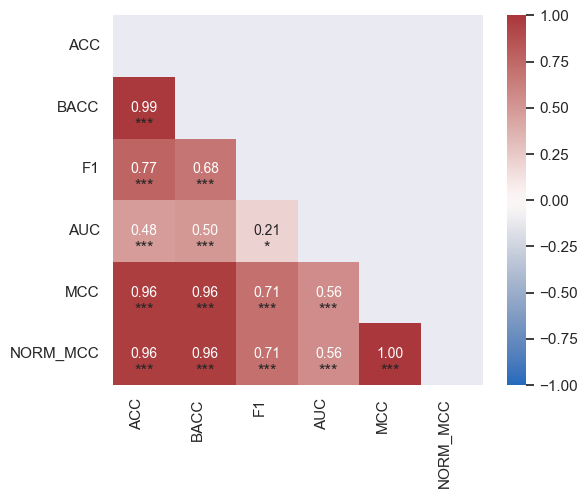

In [39]:
# change, spearman
g = corr_heatmap_with_significance(df_metric_diff[accuracy_map], acc=True)
g.figure.savefig('./Heatmap/'+data_name+'_change_acc_corr'+'.png', bbox_inches='tight')
# corr_heatmap_with_significance(results_all_converted[accuracy_map+fairness_map])

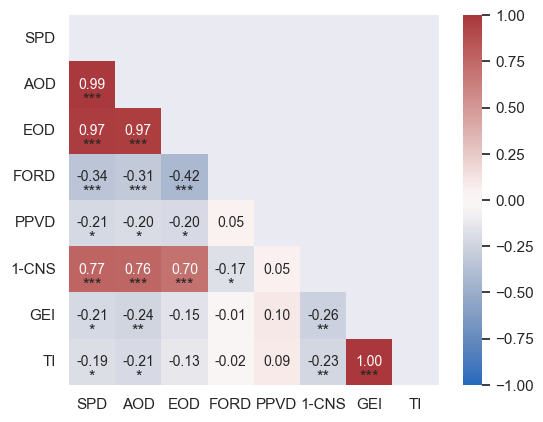

In [40]:
# change, spearman
g = corr_heatmap_with_significance(df_metric_diff[fairness_map])
g.figure.savefig('./Heatmap/'+data_name+'_change_fair_corr'+'.png', bbox_inches='tight')
# corr_heatmap_with_significance(results_all_converted[accuracy_map+fairness_map])